# Prelude

Connect the notebook local directory to Google drive for easy access to the data

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install lmfit
clear_output()

In [ ]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import optimize
import scipy as scipy
from lmfit.models import ConstantModel, LorentzianModel

In [ ]:
if os.path.isdir("/content/heterodyne/") and os.path.isdir("/content/split_detection/"):
    pass
else:
    !unzip /content/drive/MyDrive/allan_data/heterodyne.zip
    !unzip /content/drive/MyDrive/allan_data/split_detection.zip
clear_output()

# Processing Methods

These methods make it easy to load in .CSV files containing the spectra data.

In [ ]:
def columns_to_array(df):
    """
    Create individual numpy arrays from columns of a data frame

    Args:
    df (pd.DataFrame):  The data frame to convert

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """
    result = []
    for _, col_data in df.iteritems():
        result.append(col_data.values)
    return result

def load_csv_file(fullpath, units):
    """
    Load a single csv file into memory as a pandas.DataFrame
    
    Args:
    fullpath (str):  The full path to the CSV file

    units (str):  Units to use for the spectral density.
                  Typically m^2/Hz or V^2/Hz.
    """
    return pd.read_csv(fullpath, names=["Frequency (Hz)", f"Spectral Density ({units})"])

def process_csv_file(fullpath, units):

    """
    Load a single CSV file into memeory as numpy arrays

    Args:
    fullpath (str):  The full path to the CSV file

    units (str):  Units to use for the spectral density.
                  Typically m^2/Hz or V^2/Hz.

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """

    df = load_csv_file(fullpath, units)

    return columns_to_array(df)

def match_filenames_in_dir(pattern, dirpath):

    """
    Search a directory tree for all filenames which match a specified pattern

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.

    Returns:
    (list(str)):  List of all the filenames which match a specified pattern.
    """

    # List of all found files that match pattern
    result = []
    # Walk the tree
    for root, dirs, files in os.walk(dirpath):
        # Only care about files within the directory
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [ ]:
def sort_key(fullpath):
    """
    Find the file number from the path to a file.
    Example:  Extract the number 109 from /.../cha_st80_109.CSV

    Args:
    fullpath (str):  The full path to the CSV file

    Returns:
    (int):  The found file number
    """

    filename = fullpath.split('/')[-1]
    filenumber = filename.split('_')[-1].strip(".CSV")
    return int(filenumber)

# Constant Patterns for Data sets

In [ ]:
data_sets = {"cha":{"directory":"/content/split_detection/",
                    "pattern":"cha_st80_*.CSV",
                    "units":"m^2/Hz"},
             "chb":{"directory":"/content/split_detection/",
                    "pattern":"chb_st80_*.CSV",
                    "units":"m^2/Hz"},
             "het":{"directory":"/content/heterodyne/",
                    "pattern":"het_st80_*.CSV",
                    "units":"V^2/Hz"}}

# Visualize the Data

Superimpose the data onto a single plot (one for each data set) to get a general sense for shape and magnitude.

In [ ]:
def super_plot(pattern, directory, title, units="m^2/Hz"):

    """
    Superimpose all spectra found within a directory onto a single plot

    Args:
    pattern (str):  Expression for the filename template.

    directory(str):  Path to directory where data files are located.
    """
    
    # Get a list of files
    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)
    
    # Set up a single figure 
    fig = plt.figure()
    ax = fig.add_subplot(111, title=title, xlabel="Frequency (Hz)", ylabel=f"Spectral Density ({units})")

    # Add lines to the figure
    for path in filepaths:
        df = load_csv_file(path, f"{units}")
        freq = df["Frequency (Hz)"]
        spectra = df[f"Spectral Density ({units})"]
        ax.plot(freq, spectra)
    
    plt.show()
    return 

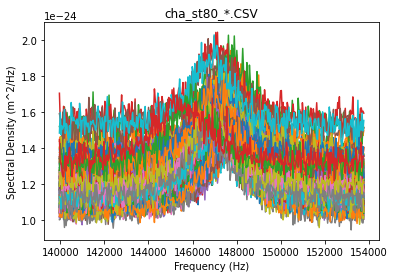

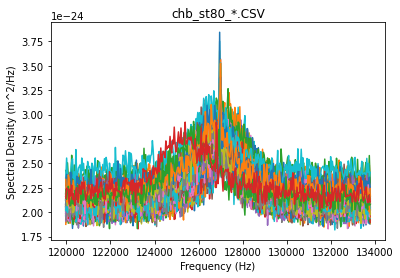

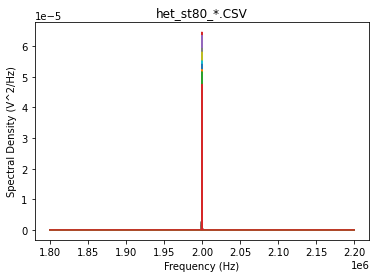

In [ ]:
for data in data_sets.values():
    super_plot(data["pattern"], data["directory"], data["pattern"], data["units"])
    print("\n")

For the Heterodyne data, it would be helpful to focus the view on the central peak.

In [ ]:
def center_zoom(arr, window):
    """
    Trim an array to select a centered view of size `window` 

    Args:
    arr (np.ndarray):  An array of values.

    window (int):  The size of the window to view.

    Returns:
    (np.ndarray):  The same as `arr` with window//2 elements to the left and 
                   right of the midpoint.
    """

    center = len(arr)//2
    left = center-window//2
    right = center+window//2
    selection = arr[left:right]
    return selection 

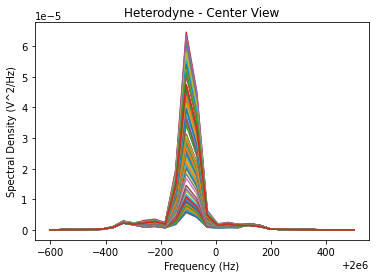

In [ ]:
window_size = 30
units = "V^2/Hz" # Since looking at heterodyne data

# Get a list of files
filepaths = match_filenames_in_dir(data_sets["het"]["pattern"], data_sets["het"]["directory"])
filepaths.sort(key=sort_key)

# Set up a single figure 
fig = plt.figure()
ax = fig.add_subplot(111, title="Heterodyne - Center View", xlabel="Frequency (Hz)", ylabel=f"Spectral Density ({units})")

# Add lines to the figure
for path in filepaths:
    df = load_csv_file(path, f"{units}")
    freq = center_zoom(df["Frequency (Hz)"], window_size)
    spectrum = center_zoom(df[f"Spectral Density ({units})"], window_size)
    ax.plot(freq, spectrum)

plt.show()


# Lorentzian Fit

As seen in the previous section, sideband data (`cha_...` and `chb_...`) contain a single peak. A spectrum can be fit with the Lorentzian. 

In the following section, a fitting procedure is defined.

In [ ]:
def lorentz_1d(x, amp, sigma, center):
    """
    Implement a single peak Lorentzian according to the formula at
    https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Lorentz1D.html

    Args:
    x (np.ndarray):  Values the where the Lorentzian should be computed.

    amp (float):  The amplitude of the peak.

    sigma (float):  The FWHM value of the peak. 

    center (float):  The value in the domain where the peak occurs.

    Returns:
    (np.ndarray(float)):  Values of the Lorentzian 

    """
    return (amp*sigma**2)/(sigma**2+(x-center)**2)

---

In [ ]:
def plot_best_fit(freq, spectrum, best_fit_arr, title, units="m^2/Hz"):
    """
    Plot the best fit curve on top of the measured spectral density

    Args:
    freq (np.ndarray(float)):  A row array of frequency values.

    spectrum (np.ndarray(float)):  A row array of spectral density values. 
                                   Example:  Values found in chb_st80_10 as a row array

    best_fit_arr (np.ndarray(float)):  Values of the best fit curve as a row array

    title (str):  The title of the plot. Typically the file pattern or filename.

    units (str, optional):  Units to use for the spectral density.
                            Typically m^2/Hz or V^2/Hz.  
    """

    # Plot the raw data
    plt.plot(freq, spectrum, label="Spectral Density")
    # Plot the best fit curve
    plt.plot(freq, best_fit_arr, label="Best Fit")

    plt.legend()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(f"Spectra ({units})")
    plt.title(title)
    
    plt.show()
    
    return 

In [ ]:
def extract_single_peak(freq, spectrum):
    # TODO:  Write a class to access attributes instead of indexing into a dict

    """
    Applies a Lorentzian fit function to the peak and extract 
    its area, mechanical frequency, and linewidth

    Args:
    freq (np.ndarray(float)):  A row array of frequency values.

    spectrum (np.ndarray(float)):  A row array of spectral density values. 
                                   Example:  Values found in chb_st80_10 as a row array

    Returns:
    (dict):
        "raw area" (float):  The area under the data curve, before a fit is applied.
        
        "fit area" (float):  The area under the best fit curve. 
        
        "mechanical frequency" (float):  The amplitude of the peak.
        
        "linewidth" (float):  The full width at half maximum (FWHM).

        "best fit object" (lmfit.model.ModelResult):  The best fit model object.
                                                      Useful for interacting with lmfit

    """
    
    # Build the model
    peak = LorentzianModel()
    background = ConstantModel()

    # Define model parameters
    pars = background.make_params(c=spectrum.min())
    pars += peak.guess(spectrum, x=freq)

    model = peak + background

    # Fit the model 
    out = model.fit(spectrum, pars, x=freq)
    
    # Extract area, mechanical frequency, and linewidth
    raw_area = np.trapz(spectrum)
    fit_area = np.trapz(out.best_fit)
    mech_freq = out.best_values["amplitude"]
    linewidth = 2*out.best_values["sigma"]


    return {"raw area":raw_area,
            "fit area":fit_area,
            "mechanical frequency":mech_freq,
            "linewidth":linewidth,
            "best fit object":out}

## Example:  Determining the Best Fit Curve and Extracting Values

The following section demonstrates finding a best fit curve for a single peak spectrum. In this case, `cha_st80_1.CSV`

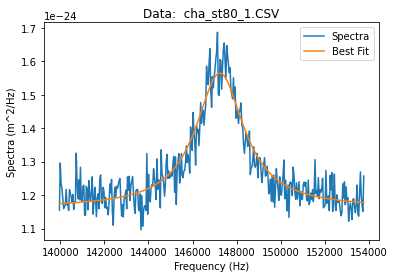

In [ ]:
# Apply fitting to just 1 spectra 
cha1 = load_csv_file("/content/split_detection/cha_st80_1.CSV", "m^2/Hz")
freq = cha1["Frequency (Hz)"]
spectrum = cha1["Spectra (m^2/Hz)"]

cha1_best_fit = extract_single_peak(freq, spectrum)["best fit object"]
plot_best_fit(freq, spectrum, cha1_best_fit.best_fit, "Data:  cha_st80_1.CSV")

Examine values from the best fit model

In [ ]:
extract_single_peak(freq, spectrum)

{'best fit object': <lmfit.model.ModelResult at 0x7f0ae1af4c90>,
 'fit area': 4.593357235347419e-22,
 'linewidth': 2670.2883529663086,
 'mechanical frequency': 1.691638732823799e-21,
 'raw area': 4.593058036684815e-22}

---

## Heterodyne Data - Multiple Peaks

For heterodyne data, we care about the two minor peaks that appear on either side of the main peak.

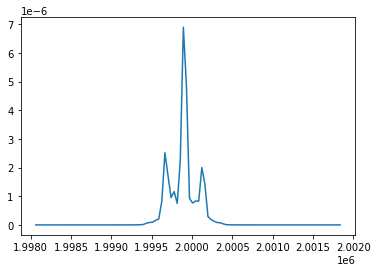

In [ ]:
# Plot a heterodyne spectra to visualize the left and right peaks

window_size = 100

het1 = load_csv_file("/content/heterodyne/het_st80_17.CSV", "V^2/Hz")

het1_freq = center_zoom(het1["Frequency (Hz)"], window_size)
het1_spectra = center_zoom(het1["Spectra (V^2/Hz)"], window_size)

plt.plot(het1_freq, het1_spectra)
plt.show()

Might have to tweak the `rel_height` parameter to get the desired minor peaks.

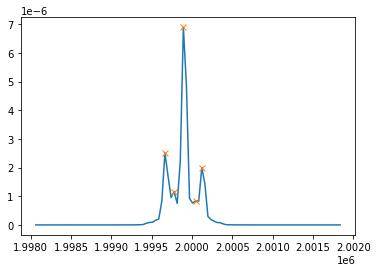

In [ ]:
# Threshold for minor peak heights relative to the center, major peak height
rel_height = 0.05
peaks, _ = find_peaks(het1_spectra, height=rel_height*het1_spectra.max())
plt.plot(het1_freq, het1_spectra)
plt.plot(het1_freq.to_numpy()[peaks], het1_spectra.to_numpy()[peaks], "x")
plt.show()

When fitting a model, we need to provide a guess for the center of the peak. If we sort the peaks by the associated height, then the major peak should be the largest value and the 2 minor peaks should be (close to) the next 2 largest values.

In [ ]:
heights_and_indices = list(zip(het1_spectra.to_numpy()[peaks], peaks))
heights_and_indices.sort(key=lambda pair : pair[0], reverse=True)
heights_and_indices

[(6.898202039418318e-06, 48),
 (2.516917701924757e-06, 42),
 (2.001028659126659e-06, 54),
 (1.1639733471022811e-06, 45),
 (8.350861423750274e-07, 52)]

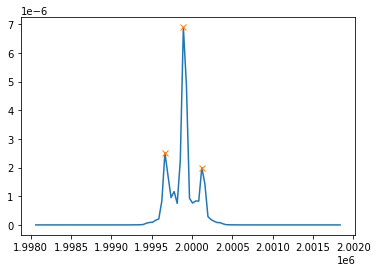

In [ ]:
desired_heights = [pair[0] for pair in heights_and_indices[:3]]
desired_indices = [pair[1] for pair in heights_and_indices[:3]]

plt.plot(het1_freq, het1_spectra)
plt.plot(het1_freq.to_numpy()[desired_indices], desired_heights, "x")

Now we can make the composite model

In [ ]:
hfreq = het1_freq.to_numpy()
hspec = het1_spectra.to_numpy()

In [ ]:
desired_indices

[48, 42, 54]

In [ ]:
desired_heights

[6.898202039418318e-06, 2.516917701924757e-06, 2.001028659126659e-06]

In [ ]:
cent_model = LorentzianModel(prefix="center_")
pars = cent_model.guess(hspec, x=hfreq)



minor1 = LorentzianModel(prefix="minor1_")
pars.update(minor1.make_params())

pars["minor1_center"].set(value=hfreq[desired_indices[1]])
pars["minor1_amplitude"].set(value=desired_heights[1])



minor2 = LorentzianModel(prefix="minor2_")
pars.update(minor2.make_params())

pars["minor2_center"].set(value=hfreq[desired_indices[2]])
pars["minor2_amplitude"].set(value=desired_heights[2])

combined_model = cent_model + minor1 + minor2
out = combined_model.fit(hspec, pars, x=hfreq)

components = out.eval_components(x=hfreq)

print(out.fit_report())

[[Model]]
    ((Model(lorentzian, prefix='center_') + Model(lorentzian, prefix='minor1_')) + Model(lorentzian, prefix='minor2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15862
    # data points      = 100
    # variables        = 9
    chi-square         = 8.7310e-12
    reduced chi-square = 9.5945e-14
    Akaike info crit   = -2988.93099
    Bayesian info crit = -2965.48446
[[Variables]]
    center_amplitude:  0.02192700 +/- 72.3445337 (329933.59%) (init = 0.01628211)
    center_center:     1999910.45 +/- 2.01757118 (0.00%) (init = 1999893)
    center_sigma:      0.23584824 +/- 784.765199 (332741.60%) (init = 629.4251)
    center_fwhm:       0.47169647 +/- 1569.53040 (332741.60%) == '2.0000000*center_sigma'
    center_height:     0.02959353 +/- 196.108950 (662675.19%) == '0.3183099*center_amplitude/max(1e-15, center_sigma)'
    minor1_amplitude:  9.5600e-04 +/- 2.2274e-04 (23.30%) (init = 2.516918e-06)
    minor1_center:     1999831.27 +/- 39.19112

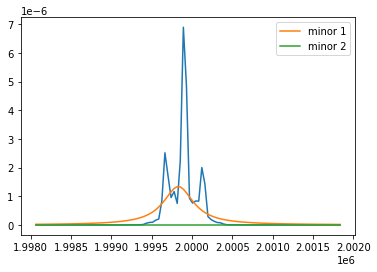

In [ ]:
plt.plot(hfreq, hspec)
#plt.plot(hfreq, out.best_fit)
plt.plot(hfreq, components["minor1_"], label="minor 1")
plt.plot(hfreq, components["minor2_"], label="minor 2")
plt.legend()

Estimate the min/max guessing range as half the distance between a minor peak and the center peak.

In [ ]:
estimated_width = (hfreq[desired_indices[0]]-hfreq[desired_indices[1]])/2
alpha = 3

In [ ]:
cent_model = LorentzianModel(prefix="center_")
pars = cent_model.guess(hspec, x=hfreq)



minor1 = LorentzianModel(prefix="minor1_")
pars.update(minor1.make_params())

pars["minor1_center"].set(value=hfreq[desired_indices[1]], 
                          min=hfreq[desired_indices[1]]+alpha*estimated_width, 
                          max=hfreq[desired_indices[1]]+2*alpha*estimated_width)

pars["minor1_amplitude"].set(value=desired_heights[1])



minor2 = LorentzianModel(prefix="minor2_")
pars.update(minor2.make_params())

pars["minor2_center"].set(value=hfreq[desired_indices[2]],
                          min=hfreq[desired_indices[2]]+alpha*estimated_width,
                          max=hfreq[desired_indices[2]]+2*alpha*estimated_width)
pars["minor2_amplitude"].set(value=desired_heights[2])

combined_model = cent_model + minor1 + minor2
out = combined_model.fit(hspec, pars, x=hfreq)

components = out.eval_components(x=hfreq)

print(out.fit_report())

[[Model]]
    ((Model(lorentzian, prefix='center_') + Model(lorentzian, prefix='minor1_')) + Model(lorentzian, prefix='minor2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 582
    # data points      = 100
    # variables        = 9
    chi-square         = 4.5435e-11
    reduced chi-square = 4.9929e-13
    Akaike info crit   = -2823.99074
    Bayesian info crit = -2800.54420
##  Warning: uncertainties could not be estimated:
    minor1_center:     at initial value
    minor1_center:     at boundary
    minor2_center:     at initial value
    minor2_center:     at boundary
[[Variables]]
    center_amplitude: -7.2063e-04 (init = 0.01628211)
    center_center:     1999370.56 (init = 1999893)
    center_sigma:      266.934906 (init = 629.4251)
    center_fwhm:       533.869813 == '2.0000000*center_sigma'
    center_height:    -8.5932e-07 == '0.3183099*center_amplitude/max(1e-15, center_sigma)'
    minor1_amplitude:  0.00400320 (init = 2.516918e-06)
    mi

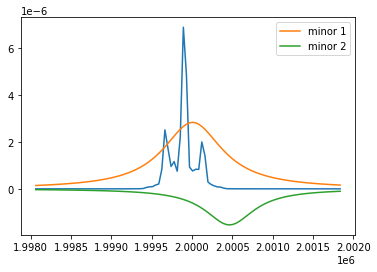

In [ ]:
plt.plot(hfreq, hspec)
#plt.plot(hfreq, out.best_fit)
plt.plot(hfreq, components["minor1_"], label="minor 1")
plt.plot(hfreq, components["minor2_"], label="minor 2")
plt.legend()

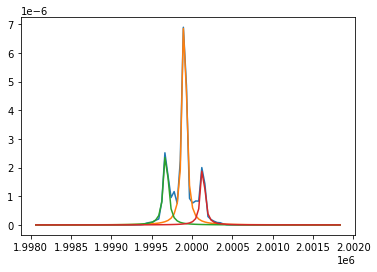

In [ ]:
def _1Lorentzian(x, amp, cen, wid):
    return amp*wid**2/((x-cen)**2+wid**2)

def _3Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2, amp3,cen3,wid3):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2)) +\
                (amp3*wid3**2/((x-cen3)**2+wid3**2))

amp1, amp2, amp3 = desired_heights
cen1, cen2, cen3 = hfreq[desired_indices]
wid1, wid2, wid3 = (10, 5, 5) # These are purely random guesses
popt_3lorentz, pcov_3lorentz = scipy.optimize.curve_fit(_3Lorentzian, hfreq, hspec, p0=[amp1, cen1, wid1, \
                                                                                    amp2, cen2, wid2, amp3, cen3, wid3])

perr_3lorentz = np.sqrt(np.diag(pcov_3lorentz))

pars_1 = popt_3lorentz[0:3]
pars_2 = popt_3lorentz[3:6]
pars_3 = popt_3lorentz[6:9]
lorentz_peak_1 = _1Lorentzian(hfreq, *pars_1)
lorentz_peak_2 = _1Lorentzian(hfreq, *pars_2)
lorentz_peak_3 = _1Lorentzian(hfreq, *pars_3)

plt.plot(hfreq, hspec)
plt.plot(hfreq, lorentz_peak_1)
plt.plot(hfreq, lorentz_peak_2)
plt.plot(hfreq, lorentz_peak_3)

# How Does Applying a Fit Affect Area Under Peak?

- Try: Simpson's rule 
    - 100x the percent error
    - Reverted back to only using the trapezoid rule

In [ ]:
# Calculate the percent error between the area under
# the raw spectra data and the area under the best fit curve
pct_err = lambda a, e : 100*abs(e-a)/abs(a)

In [ ]:
def single_peak_area_differences(dataset):

    """
    Compute the percent difference between the area under the 
    Lorentzian fit and the raw data using the trapezoid integration rule
    """

    directory = dataset["directory"]
    pattern = dataset["pattern"]
    units = dataset["units"]

    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)

    trapz_errors = []
    simpson_errors = []

    for path in filepaths:
        df = load_csv_file(path, units)
        freq = df["Frequency (Hz)"]
        spectrum = df[f"Spectra ({units})"]

        best_fit = extract_single_peak(freq, spectrum)
        trapz_errors.append(pct_err(best_fit["raw area"], best_fit["fit area"]))
    
    plt.bar(np.arange(1, 125), trapz_errors, label="Trapezoid Rule")
    plt.legend()
    plt.xlabel("File Number")
    plt.ylabel("Percent Error (%)")
    plt.title(f"Data Set:  {pattern}")
    plt.show()
    return 

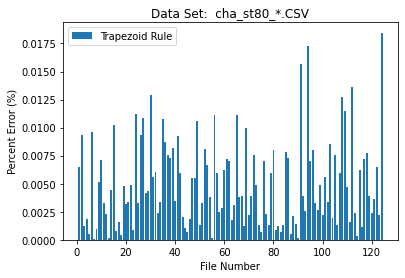

In [ ]:
# Channel A
single_peak_area_differences(data_sets["cha"])

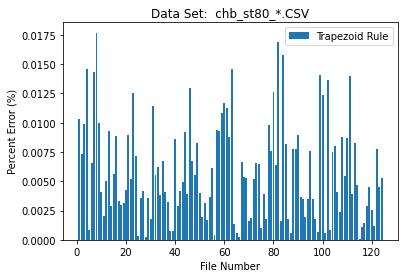

In [ ]:
# Channel B
single_peak_area_differences(data_sets["chb"])

In [ ]:
# The way to load in .dat files
areax = np.loadtxt("/content/split_detection/areay.dat")
len(areax)

124